In [1]:
from libemg.feature_extractor import FeatureExtractor
import numpy as np
import itertools
import re
import os
from typing import Dict, List
from itertools import combinations

import pandas as pd

from matplotlib import pyplot as plt

from emgstatedetect.providers.biopatrec.biopatrec_classes import BioPatRecRecordingDataset
from emgstatedetect.providers.biopatrec.biopatrec_libemg_adapters.adapter_10mov4chFU_AFEs import Device, ValuesState, AnalogFrontEnd_UntargetedForearm
from emgstatedetect.visualizations.plots import plot_multisubject_multiclass_multichannel, plot_raw_segmented_clean_one_subject_one_class
from emgstatedetect.state_detection.class_asignment import map_window_labels_to_samples_by_voting, assign_class_to_labels
from emgstatedetect.data_stages.stages import *

/usr/local/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Bluepy not installed...


In [2]:
dataset = BioPatRecRecordingDataset('10mov4chFU_AFEs', '10mov4chFU_AFEs', persist_source=True)

TIADS1299_dataset = AnalogFrontEnd_UntargetedForearm(dataset_info=dataset.info, device=Device.ADS)

2025-06-08 07:20:26 [INFO] biopatrec_classes.__init__: Initializing BioPatRecRecordingDataset for: 10mov4chFU_AFEs
2025-06-08 07:20:26 [INFO] biopatrec_classes.__init__: Local folder '10mov4chFU_AFEs' exists and contains mat files. Loading existing .mat files.


Local folder path: /workspaces/EMGStateDetect/10mov4chFU_AFEs


In [3]:
# Load the raw stage data
TIADS1299_dataset.load_data(RawStage)

80 data files fetched out of 80 files.


In [4]:
TIADS1299_dataset.get_frequency_filtered_data()
TIADS1299_dataset.persist_data(FrequencyFilteredStage)

In [5]:
TIADS1299_dataset.clean_data(AllKmeansNoRestStage)
TIADS1299_dataset.load_data(AllKmeansNoRestStage)
TIADS1299_dataset.persist_data(AllKmeansNoRestStage)

Processing subject 0, class 0, (36000, 4)
Processing subject 0, class 1, (36000, 4)
Processing subject 0, class 2, (36000, 4)
Processing subject 0, class 3, (36000, 4)
Processing subject 0, class 4, (36000, 4)
Processing subject 0, class 5, (36000, 4)
Processing subject 0, class 6, (36000, 4)
Processing subject 0, class 7, (36000, 4)
Processing subject 0, class 8, (36000, 4)
Processing subject 0, class 9, (36000, 4)
Processing subject 1, class 0, (36000, 4)
Processing subject 1, class 1, (36000, 4)
Processing subject 1, class 2, (36000, 4)
Processing subject 1, class 3, (36000, 4)
Processing subject 1, class 4, (36000, 4)
Processing subject 1, class 5, (36000, 4)
Processing subject 1, class 6, (36000, 4)
Processing subject 1, class 7, (36000, 4)
Processing subject 1, class 8, (36000, 4)
Processing subject 1, class 9, (36000, 4)
Processing subject 2, class 0, (36000, 4)
Processing subject 2, class 1, (36000, 4)
Processing subject 2, class 2, (36000, 4)
Processing subject 2, class 3, (36

In [6]:
TIADS1299_dataset.clean_data(TrainKmeansNoRestStage)
TIADS1299_dataset.load_data(TrainKmeansNoRestStage)
TIADS1299_dataset.persist_data(TrainKmeansNoRestStage)

Processing subject 0, class 0, (36000, 4)
Processing subject 0, class 1, (36000, 4)
Processing subject 0, class 2, (36000, 4)
Processing subject 0, class 3, (36000, 4)
Processing subject 0, class 4, (36000, 4)
Processing subject 0, class 5, (36000, 4)
Processing subject 0, class 6, (36000, 4)
Processing subject 0, class 7, (36000, 4)
Processing subject 0, class 8, (36000, 4)
Processing subject 0, class 9, (36000, 4)
Processing subject 1, class 0, (36000, 4)
Processing subject 1, class 1, (36000, 4)
Processing subject 1, class 2, (36000, 4)
Processing subject 1, class 3, (36000, 4)
Processing subject 1, class 4, (36000, 4)
Processing subject 1, class 5, (36000, 4)
Processing subject 1, class 6, (36000, 4)
Processing subject 1, class 7, (36000, 4)
Processing subject 1, class 8, (36000, 4)
Processing subject 1, class 9, (36000, 4)
Processing subject 2, class 0, (36000, 4)
Processing subject 2, class 1, (36000, 4)
Processing subject 2, class 2, (36000, 4)
Processing subject 2, class 3, (36

In [7]:
TIADS1299_dataset.clean_data(AllPct70NoRestStage)
TIADS1299_dataset.load_data(AllPct70NoRestStage)
TIADS1299_dataset.persist_data(AllPct70NoRestStage)

80 data files fetched out of 80 files.


In [8]:
TIADS1299_dataset.clean_data(TrainPct70NoRestStage)
TIADS1299_dataset.load_data(TrainPct70NoRestStage)
TIADS1299_dataset.persist_data(TrainPct70NoRestStage)

80 data files fetched out of 80 files.


In [9]:
import numpy as np

data = np.loadtxt('/workspaces/EMGStateDetect/10mov4chFU_AFEs/ADS/golden_data/splits.csv', delimiter=',', skiprows=1, dtype=int)
for row in data:
    subject_id = row[0]
    class_id = row[1]
    start = row[2]
    end = row[3]
    isolated_odh = TIADS1299_dataset.freq_filtered_stage.odh.\
        isolate_data('subjects',[subject_id]).\
        isolate_data('classes',[class_id])
    
    golden_split = isolated_odh.data[0][start:end,:]
    os.makedirs(f'/workspaces/EMGStateDetect/10mov4chFU_AFEs/ADS/golden_data/data/', exist_ok=True)
    np.savetxt(
        f'/workspaces/EMGStateDetect/10mov4chFU_AFEs/ADS/golden_data/data/S_{subject_id}_C_{class_id}.csv',
        golden_split,
        delimiter=',', header=','.join([f'ch{i}' for i in range(4)]), comments=''
    )

In [10]:
TIADS1299_dataset.load_data(GoldenDataStage)

80 data files fetched out of 81 files.


In [26]:
window_seconds_size = 0.25
window_seconds_step = 0.05
window_samples_size = int(window_seconds_size*2000)
window_samples_step = int(window_seconds_step*2000)

num_samples = []
num_windows = []

windows, metadata = TIADS1299_dataset.golden_data_stage.odh.parse_windows(window_samples_size,window_samples_step)
for s in np.unique(metadata['subjects']):
    for c in np.unique(metadata['classes']):
        tmp_odh = TIADS1299_dataset.golden_data_stage.odh.isolate_data('subjects', [s]).isolate_data('classes', [c])
        num_samples.append(tmp_odh.data[0].shape[0])
        tmp_windows, tmp_metadata = tmp_odh.parse_windows(window_samples_size, window_samples_step)
        num_windows.append(tmp_windows.shape[0])

print(np.mean(num_samples), np.mean(num_windows))
print(np.min(num_samples), np.min(num_windows))
print(np.max(num_samples), np.max(num_windows))

4885.5125 44.4
3932 35
5939 55


## Sanity checks

Check visually if same subject and class have similar waves in raw and frequency filtered

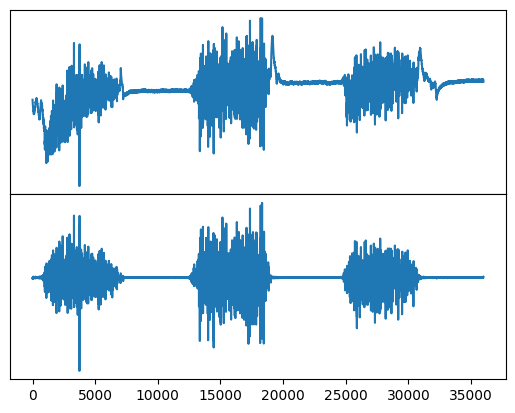

In [11]:
subject_id = 4
class_id = 1
channel_id = 2


raw_signal = TIADS1299_dataset.raw_stage.odh.\
    isolate_data('subjects', [subject_id]).\
    isolate_data('classes', [class_id])

filtered_signal = TIADS1299_dataset.freq_filtered_stage.odh.\
    isolate_data('subjects', [subject_id]).\
    isolate_data('classes', [class_id])

fig, axs = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0)
axs[0].plot(raw_signal.data[0][:,channel_id]);
axs[0].set_yticks([]);
axs[1].plot(filtered_signal.data[0][:,channel_id]);
axs[1].set_yticks([]);


Check if golden data values are equal to the last part of the filtered signal for same subject and class

In [12]:
subject_id = 7
class_id = 1
channel_id = 2

gd_df = pd.read_csv(
    '/workspaces/EMGStateDetect/10mov4chFU_AFEs/ADS/golden_data/splits.csv',
    header=0, names=['subject_id', 'class_id', 'start', 'end']
)

record = gd_df[(gd_df['subject_id'] == subject_id) & (gd_df['class_id'] == class_id)].to_dict('records')[0]


filtered_signal = TIADS1299_dataset.freq_filtered_stage.odh.\
    isolate_data('subjects', [subject_id]).\
    isolate_data('classes', [class_id]).\
    data[0][record['start']:record['end'], channel_id]

gd_signal = TIADS1299_dataset.golden_data_stage.odh.\
    isolate_data('subjects', [subject_id]).\
    isolate_data('classes', [class_id]).\
    data[0][:, channel_id]

check = np.allclose(
    filtered_signal,
    gd_signal
)

print("Same values in filtered and golden data for channel:", check)

Same values in filtered and golden data for channel: True


Check if for stage `AllKmeansNoRestStage` there are some sequence of values that match with some sequence in frequency filtered data

In [13]:
subject_id = 2
class_id = 3
channel_id = 2

def check_share_common_sequence(a: np.ndarray, b: np.ndarray, length: int = 10) -> bool:
    """
    Checks whether two numpy arrays share any common contiguous subsequence
    of the specified length. Returns True if at least one such sequence is found,
    otherwise returns False.

    Args:
        a (np.ndarray): First input array.
        b (np.ndarray): Second input array.
        length (int): Length of the subsequence to compare (default is 5).

    Returns:
        bool: True if a common subsequence of the given length exists in both arrays, False otherwise.
    """
    a_subs = {tuple(a[i:i+length]) for i in range(len(a) - length + 1)}
    b_subs = {tuple(b[i:i+length]) for i in range(len(b) - length + 1)}
    
    return not a_subs.isdisjoint(b_subs)

filtered_signal = TIADS1299_dataset.freq_filtered_stage.odh.\
    isolate_data('subjects', [subject_id]).\
    isolate_data('classes', [class_id]).\
    data[0][:, channel_id]


aknrs_signal = TIADS1299_dataset.all_kmeans_no_rest_stage.odh.\
    isolate_data('subjects', [subject_id]).\
    isolate_data('classes', [class_id]).\
    data[0][:, channel_id]

print("Same sequence in filtered and AllKmeansNoRestStage data for channel:", check_share_common_sequence(filtered_signal, aknrs_signal))

Same sequence in filtered and AllKmeansNoRestStage data for channel: True


Check if for stage `TrainKmeansNoRestStage` there are some sequence of values that match with some sequence in frequency filtered data  and if we have less values in `TrainKmeansNoRestStage`, that is created from a trimmed version of filtered data (we remove the last burst), than in `AllKmeansNoRestStage`

In [14]:
subject_id = 2
class_id = 3
channel_id = 2

filtered_signal = TIADS1299_dataset.freq_filtered_stage.odh.\
    isolate_data('subjects', [subject_id]).\
    isolate_data('classes', [class_id]).\
    data[0][:, channel_id]

aknrs_signal = TIADS1299_dataset.all_kmeans_no_rest_stage.odh.\
    isolate_data('subjects', [subject_id]).\
    isolate_data('classes', [class_id]).\
    data[0][:, channel_id]


tknrs_signal = TIADS1299_dataset.train_kmeans_no_rest_stage.odh.\
    isolate_data('subjects', [subject_id]).\
    isolate_data('classes', [class_id]).\
    data[0][:, channel_id]

print("Same sequence in filtered and TrainKmeansNoRestStage data for channel:", check_share_common_sequence(filtered_signal, tknrs_signal))
print("TrainKmeansNoRestStage have less values than AllKmeansNoRestStage:", len(tknrs_signal) < len(aknrs_signal))

Same sequence in filtered and TrainKmeansNoRestStage data for channel: True
TrainKmeansNoRestStage have less values than AllKmeansNoRestStage: True


Check if for stage `AllPct70NoRestStage` there are some sequence of values that match with some sequence in frequency filtered data and that the number of samples is almost the 70% of 6000 samples (3 seconds * 2Khz) by 3 action burst -> 12600 samples

In [15]:
subject_id = 2
class_id = 3
channel_id = 2

filtered_signal = TIADS1299_dataset.freq_filtered_stage.odh.\
    isolate_data('subjects', [subject_id]).\
    isolate_data('classes', [class_id]).\
    data[0][:, channel_id]

ap70nrs_signal = TIADS1299_dataset.all_pct70_no_rest_stage.odh.\
    isolate_data('subjects', [subject_id]).\
    isolate_data('classes', [class_id]).\
    data[0][:, channel_id]

print("Same sequence in filtered and AllPct70NoRestStage data for channel:",check_share_common_sequence(filtered_signal, ap70nrs_signal))
print(len(ap70nrs_signal), 0.7*3*2000*3)

Same sequence in filtered and AllPct70NoRestStage data for channel: True
12599 12599.999999999996


Check if for stage `TrainPct70NoRestStage` there are some sequence of values that match with some sequence in frequency filtered data and that the number of samples is almost the 70% of 6000 samples (3 seconds * 2Khz) by 2 action burst -> 12600 samples (In Train... stage data we have removed the last burst.

In [16]:
subject_id = 2
class_id = 3
channel_id = 2

filtered_signal = TIADS1299_dataset.freq_filtered_stage.odh.\
    isolate_data('subjects', [subject_id]).\
    isolate_data('classes', [class_id]).\
    data[0][:, channel_id]

tp70nrs_signal = TIADS1299_dataset.train_pct70_no_rest_stage.odh.\
    isolate_data('subjects', [subject_id]).\
    isolate_data('classes', [class_id]).\
    data[0][:, channel_id]

print("Same sequence in filtered and AllPct70NoRestStage data for channel:",check_share_common_sequence(filtered_signal, tp70nrs_signal))
print(len(tp70nrs_signal), 0.7*3*2000*2)

Same sequence in filtered and AllPct70NoRestStage data for channel: True
8399 8399.999999999998


## Evaluations

In [43]:
from libemg.emg_predictor import EMGClassifier
from libemg.offline_metrics import OfflineMetrics
from itertools import combinations


def get_windows(odh: OfflineDataHandler):
    window_seconds_size = 0.25
    window_seconds_step = 0.05
    window_samples_size = int(window_seconds_size*2000)
    window_samples_step = int(window_seconds_step*2000)
    windows, metadata = odh.parse_windows(window_samples_size, window_samples_step)
    
    return windows, metadata


def get_feature_set(windows):
    fe = FeatureExtractor()
    features = fe.extract_feature_group("HTD", windows, array=True)
    
    return features
    

def get_trained_classifier(odh: OfflineDataHandler):
    windows, metadata = get_windows(odh)
    features = get_feature_set(windows)
    feature_set = {
        'training_features': features,
        'training_labels': metadata['classes']
    }
    clf = EMGClassifier('LDA')
    clf.fit(feature_set)
    
    return clf


def get_test_metrics(clf: EMGClassifier, test_odh: OfflineDataHandler):
    test_windows, test_metadata = get_windows(test_odh)
    test_feature_set = get_feature_set(test_windows)
    clf_predictions, _ = clf.run(test_feature_set)
    om = OfflineMetrics()
    classification_metrics = om.extract_common_metrics(test_metadata['classes'], clf_predictions, null_label=None) 
    return classification_metrics


def get_dataset_metrics(
    train_odh: OfflineDataHandler, 
    test_odh: OfflineDataHandler, 
    classes: List, 
    train_subjects: List, 
    test_subjects: List) -> Dict[str, float]:
    
    assert set(train_subjects).isdisjoint(test_subjects), "There are common subjects in train and test sets"
    
    isolated_train_odh = train_odh.isolate_data('subjects', train_subjects).isolate_data('classes', classes)
    isolated_test_odh = test_odh.isolate_data('subjects', test_subjects).isolate_data('classes', classes)
    
    clf = get_trained_classifier(isolated_train_odh)
    metrics = get_test_metrics(clf, isolated_test_odh)
    
    return metrics

In [ ]:
results = []

for test_subject in range(8):
    availables_train_subjects = list(range(8))
    availables_train_subjects.remove(test_subject)
    
    for num_train_subjects in range(1, len(availables_train_subjects) + 1):
    
        for train_subjects in combinations(availables_train_subjects, num_train_subjects):

            for last_mov_class in range(2,10):
                test_subject_lst = [test_subject]
                train_subjects_lst = list(train_subjects)
                
                
                movements = list(range(10))[:last_mov_class]
                print(test_subject, train_subjects, movements)
            
                kmeans_metrics = get_dataset_metrics(
                    train_odh=TIADS1299_dataset.train_kmeans_no_rest_stage.odh, 
                    test_odh=TIADS1299_dataset.golden_data_stage.odh, 
                    classes=movements, 
                    train_subjects=train_subjects_lst, 
                    test_subjects=test_subject_lst
                )
                
                pct70_metrics = get_dataset_metrics(
                    train_odh=TIADS1299_dataset.train_pct70_no_rest_stage.odh, 
                    test_odh=TIADS1299_dataset.golden_data_stage.odh, 
                    classes=movements, 
                    train_subjects=train_subjects_lst, 
                    test_subjects=test_subject_lst
                )
                
                results.append({
                    'num_test_subjects': len(test_subject_lst),
                    'num_train_subjects': len(train_subjects_lst),
                    'num_movements': len(movements),
                    'test_subjects': '|'.join([str(i) for i in test_subject_lst]),
                    'train_subjects': '|'.join([str(i) for i in train_subjects_lst]),
                    'movements': '|'.join([str(i) for i in movements]),
                    'kmeans_acc': kmeans_metrics['CA'],
                    'pct70_acc': pct70_metrics['CA']
                })
                

pd.DataFrame(results).to_csv(
    '/workspaces/EMGStateDetect/backup_data/10mov4chFU_AFEs/ADS/results/all_users_all_movements_trainkmeans_vs_trainpct70_golden_test.csv',
    index=False
)

In [ ]:
df = pd.read_csv(
    '/workspaces/EMGStateDetect/backup_data/10mov4chFU_AFEs/ADS/results/all_users_all_movements_trainkmeans_vs_trainpct70_golden_test.csv'
)

In [ ]:
results = []

for test_subject in range(8):
    availables_train_subjects = list(range(8))
    availables_train_subjects.remove(test_subject)
    
    for num_train_subjects in range(1, len(availables_train_subjects) + 1):
    
        for train_subjects in combinations(availables_train_subjects, num_train_subjects):

            for last_mov_class in range(2,10):
                test_subject_lst = [test_subject]
                train_subjects_lst = list(train_subjects)
                
                
                movements = list(range(10))[:last_mov_class]
                print(test_subject, train_subjects, movements)
            
                kmeans_metrics = get_dataset_metrics(
                    train_odh=TIADS1299_dataset.all_kmeans_no_rest_stage.odh, 
                    test_odh=TIADS1299_dataset.golden_data_stage.odh, 
                    classes=movements, 
                    train_subjects=train_subjects_lst, 
                    test_subjects=test_subject_lst
                )
                
                pct70_metrics = get_dataset_metrics(
                    train_odh=TIADS1299_dataset.all_pct70_no_rest_stage.odh, 
                    test_odh=TIADS1299_dataset.golden_data_stage.odh, 
                    classes=movements, 
                    train_subjects=train_subjects_lst, 
                    test_subjects=test_subject_lst
                )
                
                results.append({
                    'num_test_subjects': len(test_subject_lst),
                    'num_train_subjects': len(train_subjects_lst),
                    'num_movements': len(movements),
                    'test_subjects': '|'.join([str(i) for i in test_subject_lst]),
                    'train_subjects': '|'.join([str(i) for i in train_subjects_lst]),
                    'movements': '|'.join([str(i) for i in movements]),
                    'kmeans_acc': kmeans_metrics['CA'],
                    'pct70_acc': pct70_metrics['CA']
                })


pd.DataFrame(results).to_csv(
    '/workspaces/EMGStateDetect/backup_data/10mov4chFU_AFEs/ADS/results/all_users_all_movements_allkmeans_vs_allnpct70_golden_test.csv',
    index=False
)          

In [17]:
df = pd.read_csv(
    '/workspaces/EMGStateDetect/backup_data/10mov4chFU_AFEs/ADS/results/all_users_all_movements_allkmeans_vs_allnpct70_golden_test.csv'
)

# Visualizations

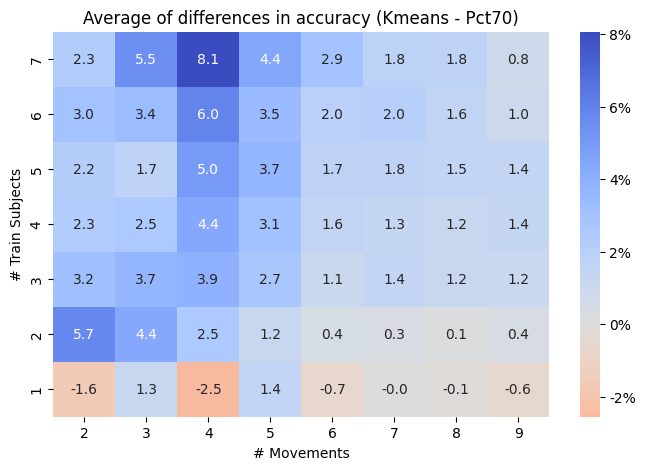

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Paso 1: Crear la columna de diferencia
df['diff'] = (df['kmeans_acc'] - df['pct70_acc'])*100

# Paso 2: Agrupar y pivotear
pivot_df = (
    df.groupby(['num_train_subjects', 'num_movements'])['diff']
    .mean()
    .reset_index()
    .pivot(index='num_train_subjects', columns='num_movements', values='diff')
)

plt.figure(figsize=(8, 5))
ax = sns.heatmap(
    pivot_df,
    annot=True,
    fmt=".1f",
    cmap="coolwarm_r",
    center=0
)

cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))

plt.title('Average of differences in accuracy (Kmeans - Pct70)')
plt.xlabel('# Movements')
plt.ylabel('# Train Subjects')
plt.gca().invert_yaxis()
plt.show()

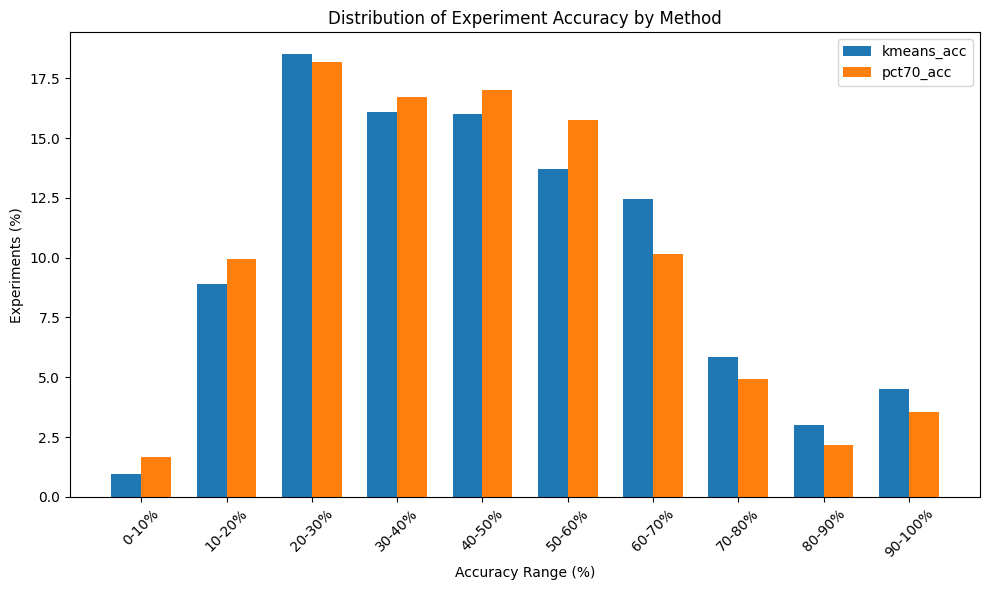

In [32]:
import pandas as pd
import numpy as np

# Suponiendo que ya tienes los bins creados
bins = np.arange(0, 1.1, 0.1)
labels = [f'{int(l*100)}-{int(r*100)}%' for l, r in zip(bins[:-1], bins[1:])]


df['kmeans_acc'] = df['kmeans_acc'].replace(1, 0.99)
df['pct70_acc'] = df['pct70_acc'].replace(1, 0.99)


df['kmeans_bin'] = pd.cut(df['kmeans_acc'], bins=bins, labels=labels, right=False, include_lowest=True)
df['pct70_bin'] = pd.cut(df['pct70_acc'], bins=bins, labels=labels, right=False, include_lowest=True)

# Cuenta los registros para cada bin
kmeans_counts = df['kmeans_bin'].value_counts().sort_index()
pct70_counts = df['pct70_bin'].value_counts().sort_index()

total_registros = len(df)

kmeans_pct = (kmeans_counts / total_registros) * 100
pct70_pct = (pct70_counts / total_registros) * 100

plot_df = pd.DataFrame({
    'kmeans_acc': kmeans_pct,
    'pct70_acc': pct70_pct
})
plot_df.index.name = 'bin'
plot_df = plot_df.reset_index()

x = np.arange(len(plot_df['bin']))  # Posiciones de los bins
width = 0.35  # Ancho de cada barra

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, plot_df['kmeans_acc'], width, label='kmeans_acc')
plt.bar(x + width/2, plot_df['pct70_acc'], width, label='pct70_acc')

plt.xlabel('Accuracy Range (%)')
plt.ylabel('Experiments (%)')
plt.title('Distribution of Experiment Accuracy by Method')
plt.xticks(x, plot_df['bin'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Worst cases analysis

In [34]:
df[df['diff']== df['diff'].min()]

,num_test_subjects,num_train_subjects,num_movements,test_subjects,train_subjects,movements,kmeans_acc,pct70_acc,diff,kmeans_bin,pct70_bin
4105,1,1,3,4,6,0|1|2,0.304688,0.99,-69.53125,30-40%,90-100%


Parece que el peor caso es:
* Train subject: 6
* Test subject: 4
* Movements: 0, 1, 2

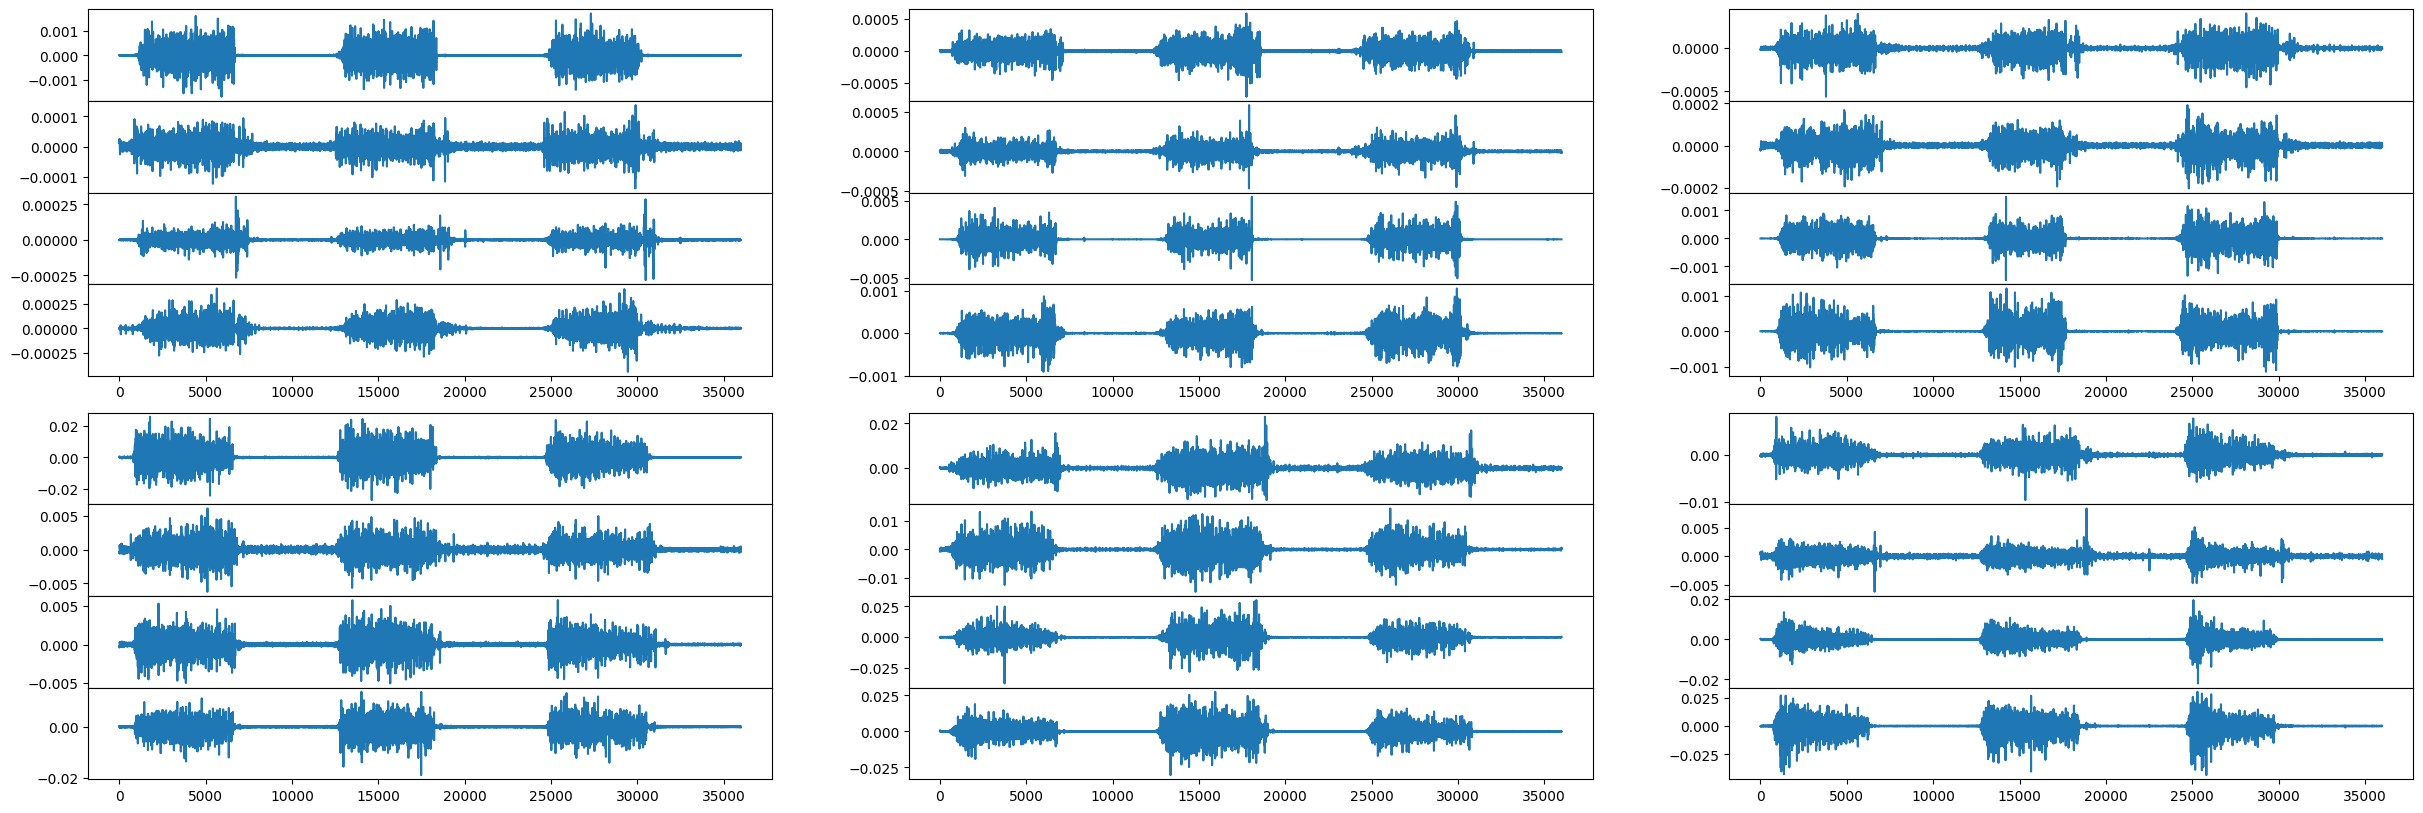

In [38]:
data = np.array(
    [
    [
        TIADS1299_dataset.freq_filtered_stage.odh.isolate_data('subjects', [6]).isolate_data('classes', [0]).data[0].transpose().reshape(4, 36000),
        TIADS1299_dataset.freq_filtered_stage.odh.isolate_data('subjects', [6]).isolate_data('classes', [1]).data[0].transpose().reshape(4, 36000),
        TIADS1299_dataset.freq_filtered_stage.odh.isolate_data('subjects', [6]).isolate_data('classes', [2]).data[0].transpose().reshape(4, 36000)
    ],
    [
        TIADS1299_dataset.freq_filtered_stage.odh.isolate_data('subjects', [4]).isolate_data('classes', [0]).data[0].transpose().reshape(4, 36000),
        TIADS1299_dataset.freq_filtered_stage.odh.isolate_data('subjects', [4]).isolate_data('classes', [1]).data[0].transpose().reshape(4, 36000),
        TIADS1299_dataset.freq_filtered_stage.odh.isolate_data('subjects', [4]).isolate_data('classes', [2]).data[0].transpose().reshape(4, 36000)
    ]
    ]
)

plot_multisubject_multiclass_multichannel(data, fig_width=30, fig_height=10);

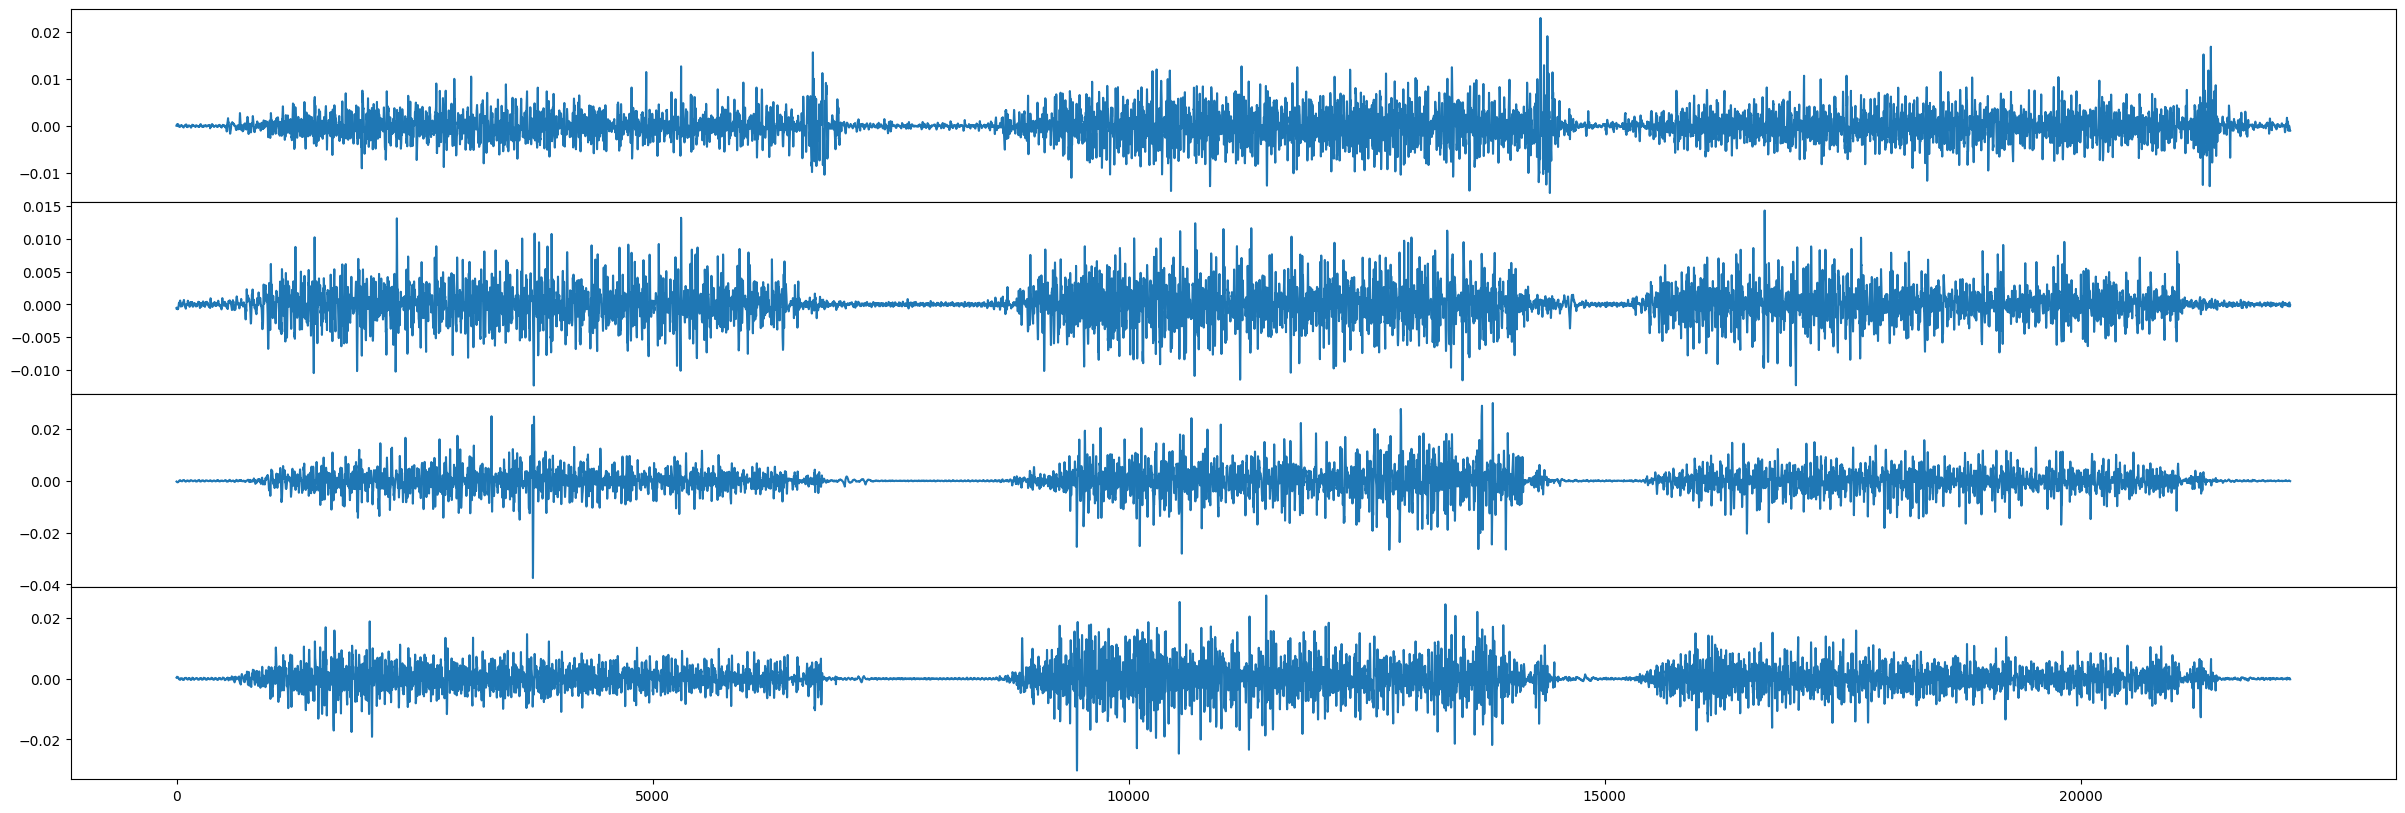

In [ ]:
data = np.array(
    [
    [
        TIADS1299_dataset.all_kmeans_no_rest_stage.odh.isolate_data('subjects', [4]).isolate_data('classes', [1]).data[0].transpose().reshape(4, TIADS1299_dataset.all_kmeans_no_rest_stage.odh.isolate_data('subjects', [4]).isolate_data('classes', [1]).data[0].shape[0]),
        #TIADS1299_dataset.all_kmeans_no_rest_stage.odh.isolate_data('subjects', [6]).isolate_data('classes', [1]).data[0].transpose().reshape(4, TIADS1299_dataset.all_kmeans_no_rest_stage.odh.isolate_data('subjects', [6]).isolate_data('classes', [1]).data[0].shape[0]),
        #TIADS1299_dataset.all_kmeans_no_rest_stage.odh.isolate_data('subjects', [6]).isolate_data('classes', [2]).data[0].transpose().reshape(4, TIADS1299_dataset.all_kmeans_no_rest_stage.odh.isolate_data('subjects', [6]).isolate_data('classes', [2]).data[0].shape[0])
    ]
    ]
)

plot_multisubject_multiclass_multichannel(data, fig_width=30, fig_height=10);

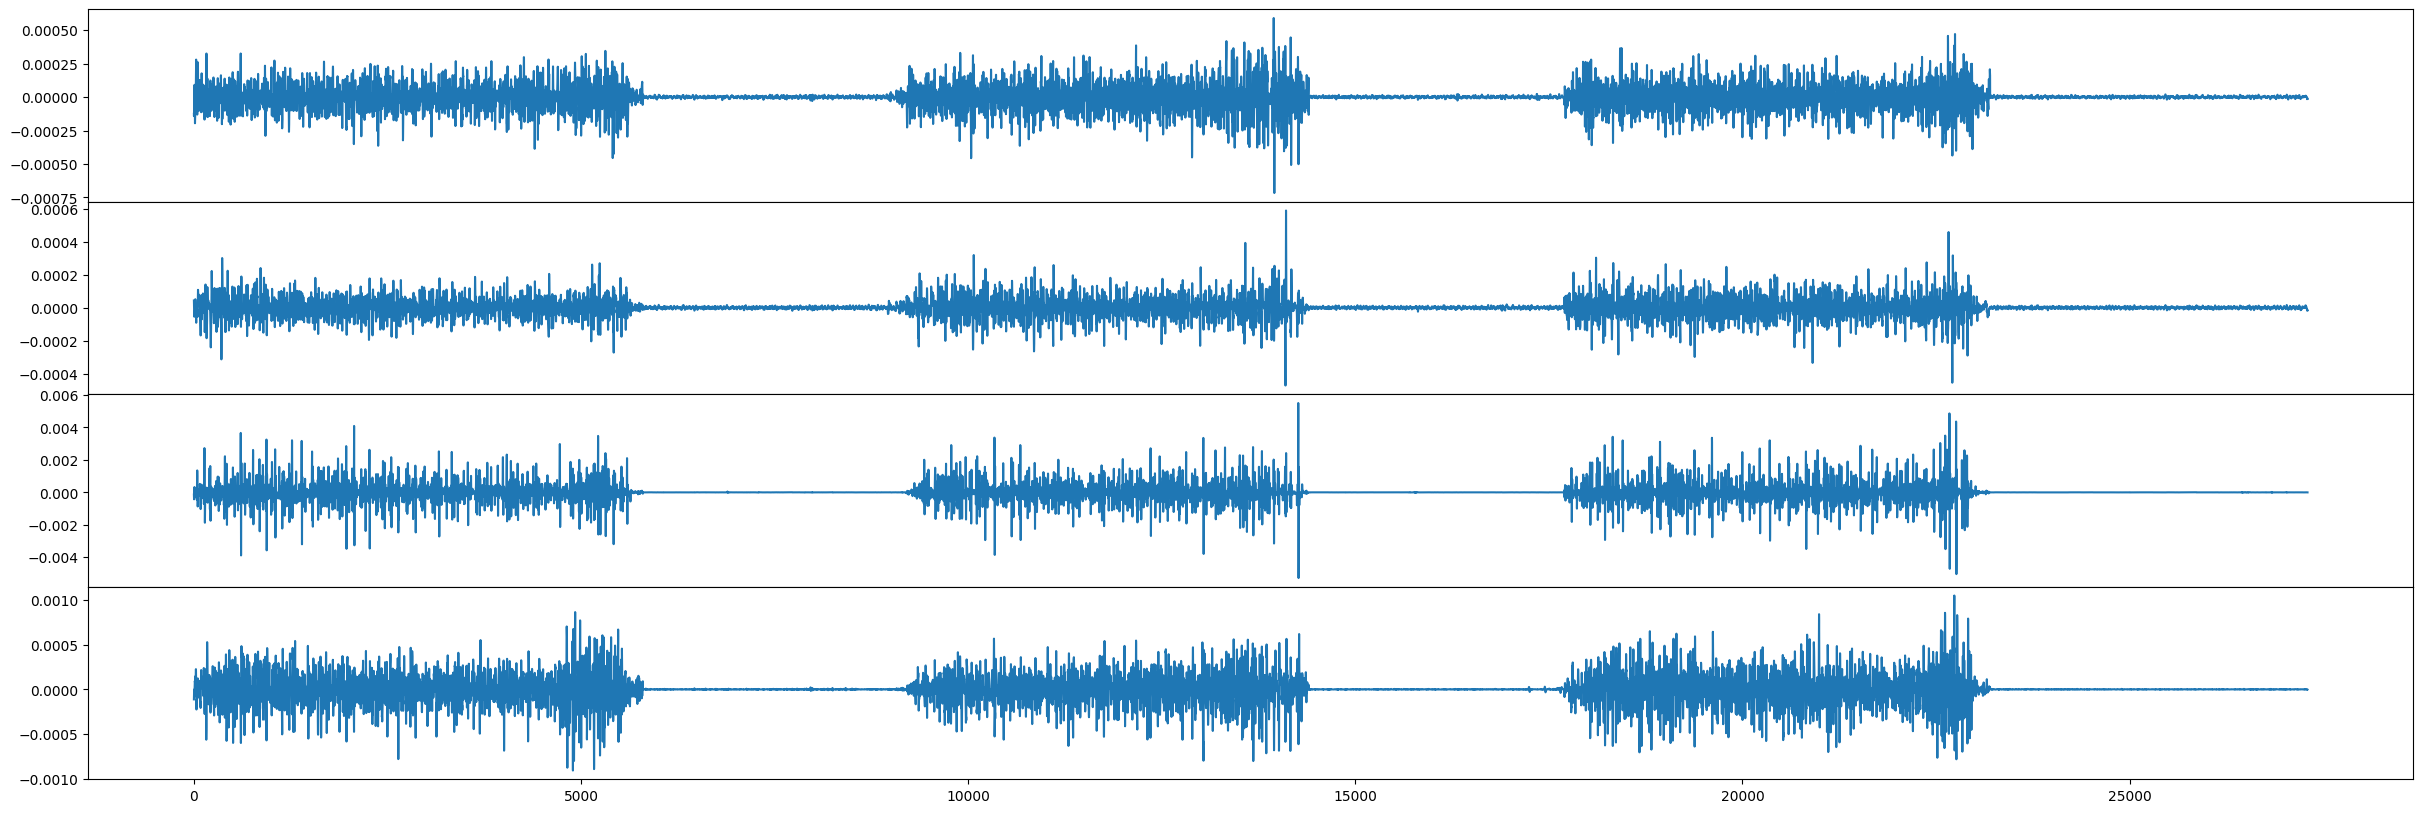

In [48]:
data = np.array(
    [
    [
        TIADS1299_dataset.all_kmeans_no_rest_stage.odh.isolate_data('subjects', [6]).isolate_data('classes', [1]).data[0].transpose().reshape(4, TIADS1299_dataset.all_kmeans_no_rest_stage.odh.isolate_data('subjects', [6]).isolate_data('classes', [1]).data[0].shape[0]),
        #TIADS1299_dataset.all_kmeans_no_rest_stage.odh.isolate_data('subjects', [6]).isolate_data('classes', [1]).data[0].transpose().reshape(4, TIADS1299_dataset.all_kmeans_no_rest_stage.odh.isolate_data('subjects', [6]).isolate_data('classes', [1]).data[0].shape[0]),
        #TIADS1299_dataset.all_kmeans_no_rest_stage.odh.isolate_data('subjects', [6]).isolate_data('classes', [2]).data[0].transpose().reshape(4, TIADS1299_dataset.all_kmeans_no_rest_stage.odh.isolate_data('subjects', [6]).isolate_data('classes', [2]).data[0].shape[0])
    ]
    ]
)

plot_multisubject_multiclass_multichannel(data, fig_width=30, fig_height=10);

## Best case

In [49]:
df[df['diff']== df['diff'].max()]

,num_test_subjects,num_train_subjects,num_movements,test_subjects,train_subjects,movements,kmeans_acc,pct70_acc,diff,kmeans_bin,pct70_bin
2240,1,2,2,2,5|7,0|1,0.842105,0.168421,67.368421,80-90%,10-20%


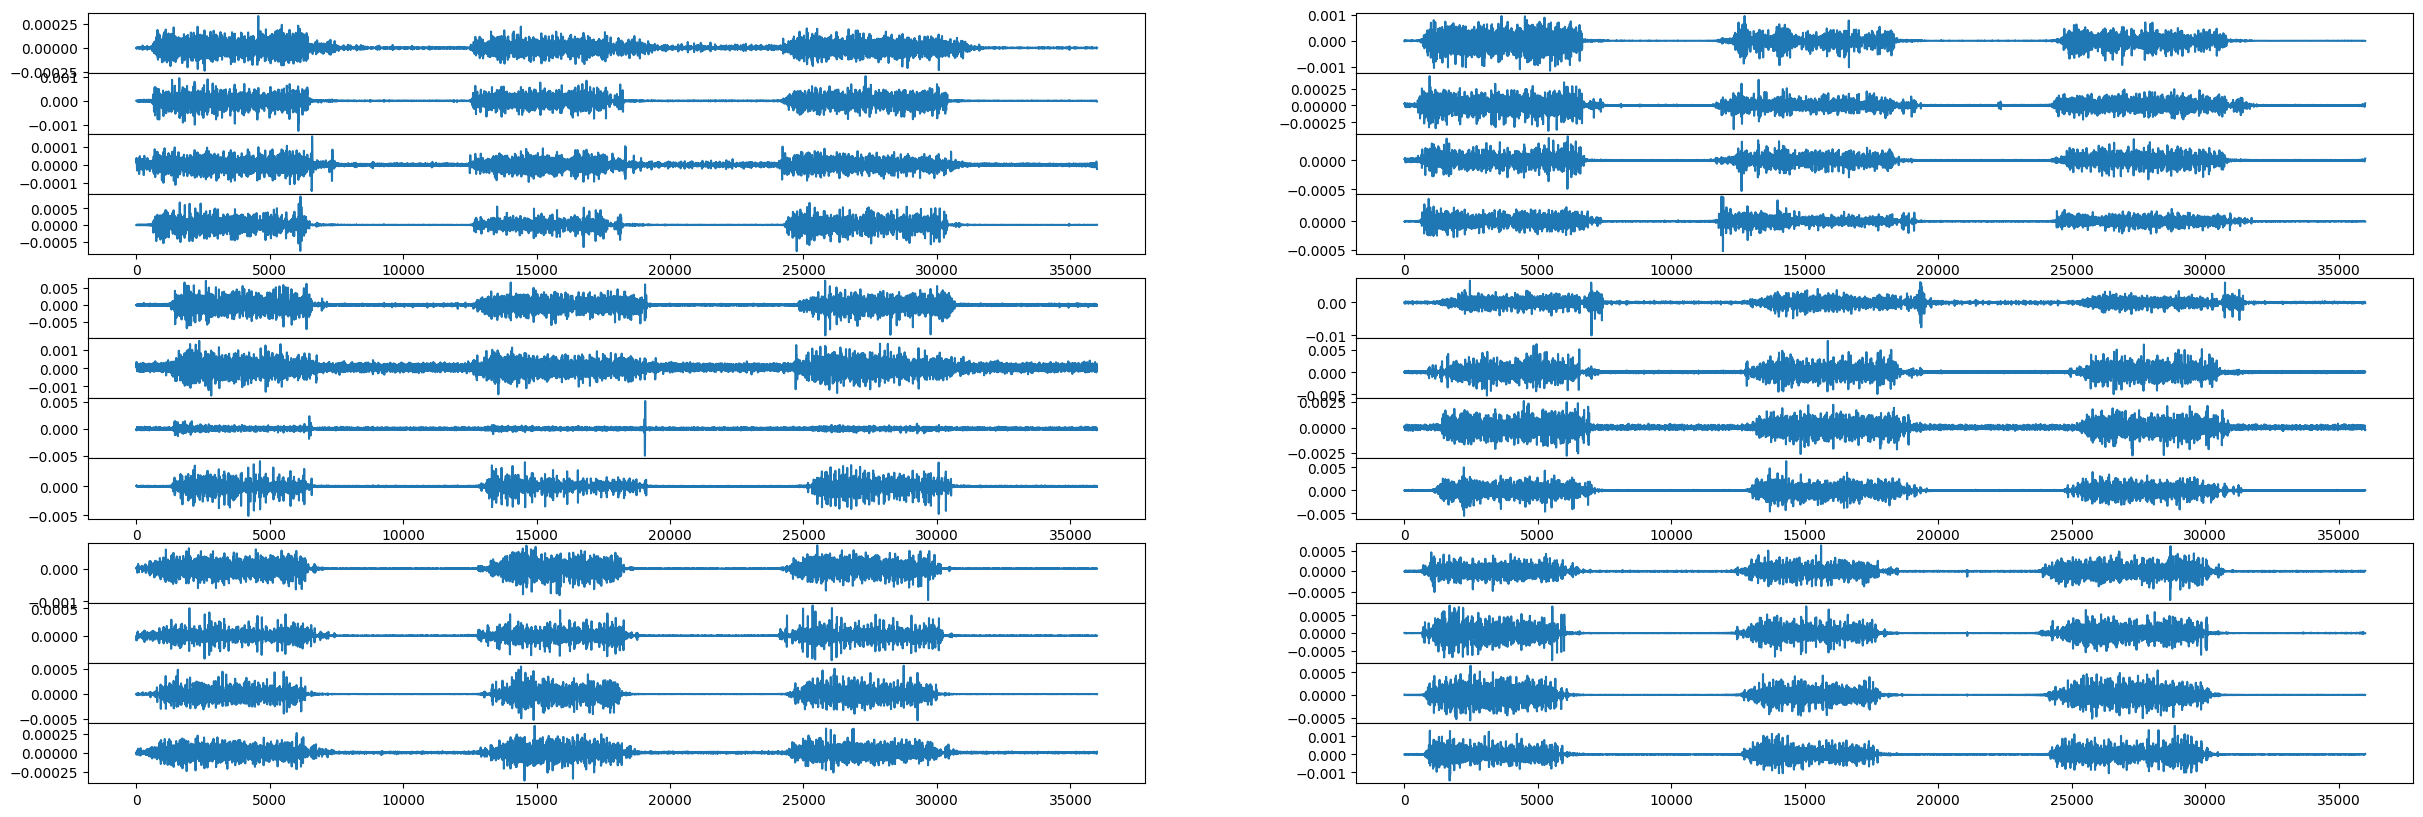

In [50]:
data = np.array(
    [
    [
        TIADS1299_dataset.freq_filtered_stage.odh.isolate_data('subjects', [2]).isolate_data('classes', [0]).data[0].transpose().reshape(4, 36000),
        TIADS1299_dataset.freq_filtered_stage.odh.isolate_data('subjects', [2]).isolate_data('classes', [1]).data[0].transpose().reshape(4, 36000)
    ],
    [
        TIADS1299_dataset.freq_filtered_stage.odh.isolate_data('subjects', [5]).isolate_data('classes', [0]).data[0].transpose().reshape(4, 36000),
        TIADS1299_dataset.freq_filtered_stage.odh.isolate_data('subjects', [5]).isolate_data('classes', [1]).data[0].transpose().reshape(4, 36000)
    ],
    [
        TIADS1299_dataset.freq_filtered_stage.odh.isolate_data('subjects', [7]).isolate_data('classes', [0]).data[0].transpose().reshape(4, 36000),
        TIADS1299_dataset.freq_filtered_stage.odh.isolate_data('subjects', [7]).isolate_data('classes', [1]).data[0].transpose().reshape(4, 36000)
    ]
    ]
)

plot_multisubject_multiclass_multichannel(data, fig_width=30, fig_height=10);

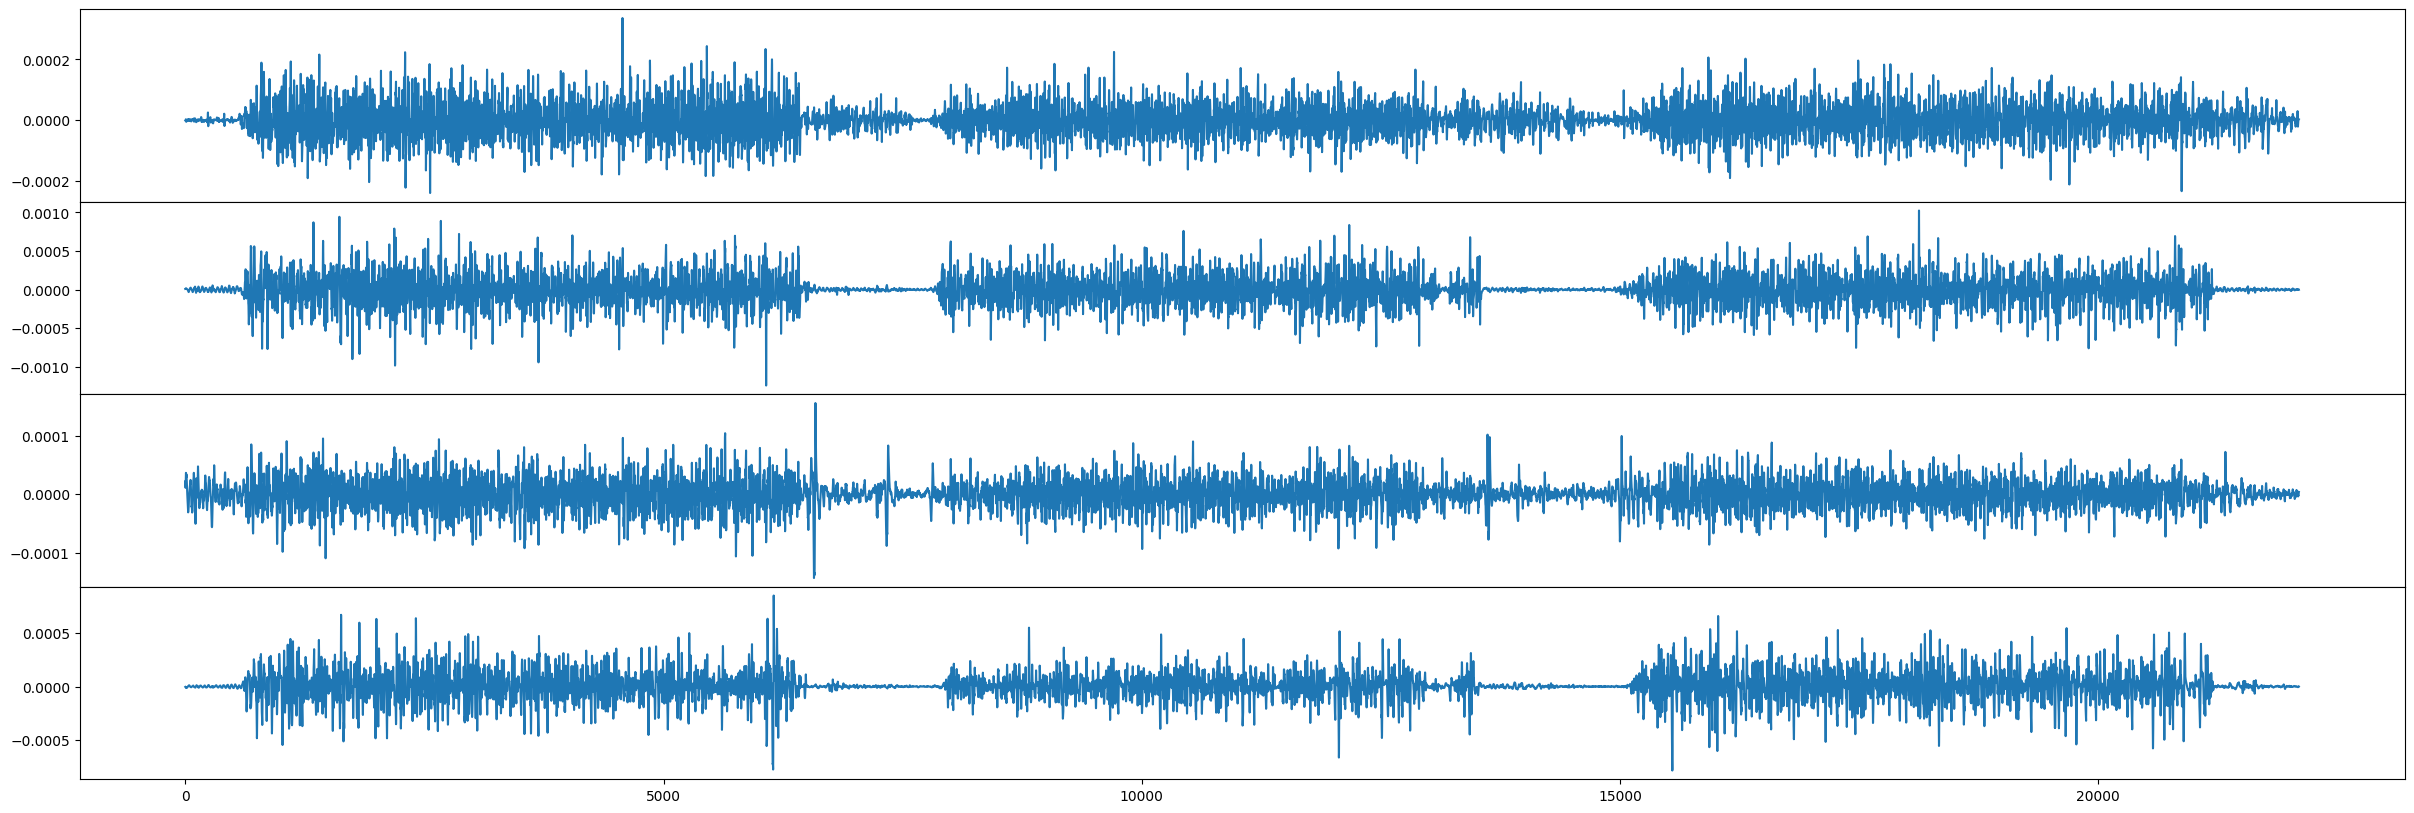

In [51]:
data = np.array(
    [
    [
        TIADS1299_dataset.all_kmeans_no_rest_stage.odh.isolate_data('subjects', [2]).isolate_data('classes', [0]).data[0].transpose().reshape(4, TIADS1299_dataset.all_kmeans_no_rest_stage.odh.isolate_data('subjects', [2]).isolate_data('classes', [0]).data[0].shape[0]),
        #TIADS1299_dataset.all_kmeans_no_rest_stage.odh.isolate_data('subjects', [6]).isolate_data('classes', [1]).data[0].transpose().reshape(4, TIADS1299_dataset.all_kmeans_no_rest_stage.odh.isolate_data('subjects', [6]).isolate_data('classes', [1]).data[0].shape[0]),
        #TIADS1299_dataset.all_kmeans_no_rest_stage.odh.isolate_data('subjects', [6]).isolate_data('classes', [2]).data[0].transpose().reshape(4, TIADS1299_dataset.all_kmeans_no_rest_stage.odh.isolate_data('subjects', [6]).isolate_data('classes', [2]).data[0].shape[0])
    ]
    ]
)

plot_multisubject_multiclass_multichannel(data, fig_width=30, fig_height=10);